## Import libries

In [1]:
import sklearn
import smogn

sklearn.set_config(enable_metadata_routing=True)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import matplotlib.pyplot as plt

## Data set load

In [2]:
df_clean = pd.read_csv('../data/cleaned/cleaned_japan_earthquake.csv')
print("Data loaded successfully.")
print(df_clean.shape)
np.random.seed(42)

Data loaded successfully.
(41457, 18)


## Define Features and Target

In [3]:
target = 'mag'
features = [col for col in df_clean.columns if col != target]
X = df_clean.drop(columns=[target])
y = df_clean[target]

print(f"Features (X): {X.shape[1]} columns")
print(f"Target (y): {y.name}")

Features (X): 17 columns
Target (y): mag


In [4]:
df_clean.columns.tolist()

['latitude',
 'longitude',
 'depth',
 'mag',
 'nst',
 'gap',
 'rms',
 'depthError',
 'magNst',
 'year',
 'month_sin',
 'month_cos',
 'hour_sin',
 'hour_cos',
 'region',
 'mag_Other',
 'mag_mb',
 'mag_ml']

## Split data into train/test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 33165, Test size: 8292


## Magnitude distribution

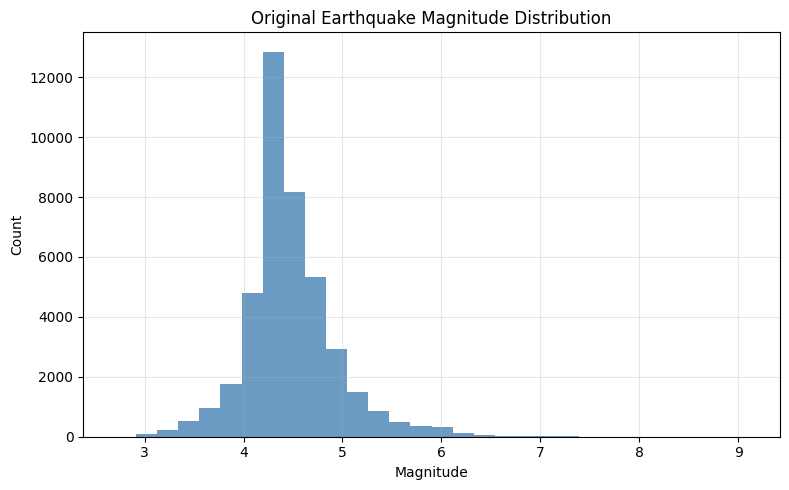

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(df_clean[target], bins=30, color='steelblue', alpha=0.8)
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Original Earthquake Magnitude Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Weights

In [7]:
weights = np.ones(len(y_train))
weights[y_train >= 6.0] *= 10
weights[y_train >= 7.0] *= 50
weights[y_train >= 8.0] *= 100

##  Hyperparameter tuning and Training the model

In [8]:
import sklearn
sklearn.set_config(enable_metadata_routing=True)
print("✅ Metadata routing ENABLED")

# --- Step 2: Define Base Models with sample_weight Request ---
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('xgb', XGBRegressor(random_state=42).set_fit_request(sample_weight=True)),
    ('lgb', LGBMRegressor(random_state=42).set_fit_request(sample_weight=True)),
    ('cat', CatBoostRegressor(
        random_state=42,
        iterations=200,
        depth=8,
        silent=True,
        allow_writing_files=False)
     )
]

# Final estimator must also request sample_weight
final_estimator = XGBRegressor(random_state=42).set_fit_request(sample_weight=True)

# Create stacked model
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=1
)

# --- Step 3: Hyperparameter Tuning ---
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'final_estimator__n_estimators': [300, 400],
    'final_estimator__max_depth': [6, 8],
    'final_estimator__learning_rate': [0.01, 0.05],
    'final_estimator__subsample': [0.8, 0.9],
    'final_estimator__cols ample_btree': [0.8, 0.9],
    'final_estimator__reg_lambda': [2, 5],

    # Tune LGBM lightly
    'lgb__num_leaves': [31, 63],
    'lgb__max_depth': [8, 10],
    'lgb__learning_rate': [0.05, 0.1],

    # Tune CatBoost lightly
    'cat__iterations': [200, 300],
    'cat__depth': [6, 8],
    'cat__learning_rate': [0.05, 0.1],
}

random_search_stacked = RandomizedSearchCV(
    estimator=stacked_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='r2',
    cv=3,
    n_jobs=1,
    verbose=2,
    random_state=42
)

# Fit with sample_weight (no prefix needed!)
print("Starting randomized search...")
random_search_stacked.fit(X_train, y_train, sample_weight=weights)

# Get best model
best_stacked_model = random_search_stacked.best_estimator_
print("✅ Best parameters found:")
print(random_search_stacked.best_params_)

✅ Metadata routing ENABLED
Starting randomized search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 22110, number of used features: 17
[LightGBM] [Info] Start training from score 5.516492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 17688, number of used features: 16
[LightGBM] [Info] Start training from score 5.509415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhea

KeyboardInterrupt: 

## Predict and evaluate

In [55]:
y_pred = best_stacked_model.predict(X_test)

# Stratified evaluation by magnitude bins
def evaluate_by_bin(y_true, y_pred, bins):
    y_true_binned = pd.cut(y_true, bins=bins, include_lowest=True)
    results = []
    for bin in y_true_binned.cat.categories:
        mask = y_true_binned == bin
        if mask.sum() > 0:
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            r2 = r2_score(y_true[mask], y_pred[mask])
            results.append({'Bin': str(bin), 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Count': mask.sum()})
    return pd.DataFrame(results)

eval_df = evaluate_by_bin(y_test, y_pred, bins)
print("\n📊 Performance by Magnitude Bin:")
print(eval_df.to_string(index=False))


📊 Asia Earthquake Model Performance (Stacked Ensemble)
  MAE      : 0.211
  RMSE     : 0.294
  R²       : 0.849

🎯 Accuracy within:
   ±0.2 magnitude: 60.4% of test samples
   ±0.3 magnitude: 77.6% of test samples


##  Global metrics

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\n📊 Global Metrics:")
print(f"  MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

##  Accuracy within thresholds

In [ ]:
errors = np.abs(y_test - y_pred)
in_02 = np.mean(errors <= 0.2) * 100
in_03 = np.mean(errors <= 0.3) * 100
print(f"\n🎯 Accuracy within:")
print(f"   ±0.2 magnitude: {in_02:.1f}%")
print(f"   ±0.3 magnitude: {in_03:.1f}%")

## Plot Actual vs Predicted

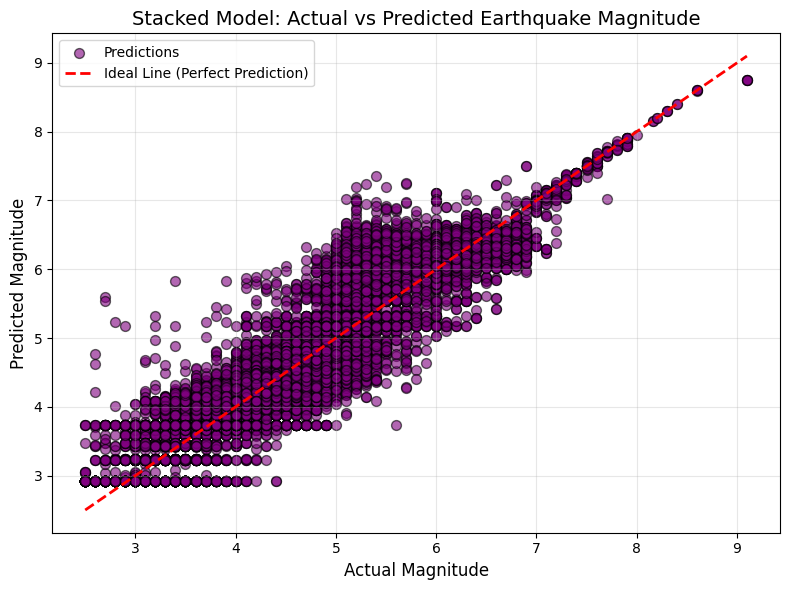

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', edgecolor='black', s=50, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Magnitude', fontsize=12)
plt.ylabel('Predicted Magnitude', fontsize=12)
plt.title('Stacked Model: Actual vs Predicted Magnitude', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/asia_stacked_actual_vs_predicted.png', dpi=300)
plt.show()

## Residual Analysis

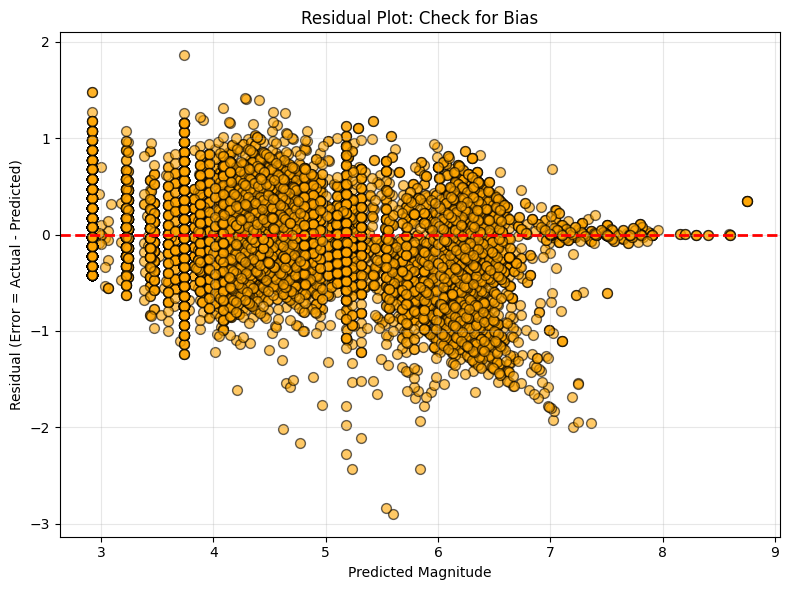


🔍 Residual Statistics:
   Mean Error (Bias): -0.029
   Std Dev of Error:  0.292


In [57]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolor='black', s=50)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residual (Error = Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/asia_stacked_residuals.png', dpi=300)
plt.show()
print(f"\n🔍 Residual Stats: Mean: {np.mean(residuals):+.3f}, Std: {np.std(residuals):.3f}")

## Feature importance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

📊 Top 10 Most Important Features:
      feature  importance_mean  importance_std
14  mag_Other         0.797885        0.004799
15     mag_mb         0.316624        0.002602
7      magNst         0.202792        0.002157
0    latitude         0.110189        0.001056
3         nst         0.100805        0.001897
8        year         0.092566        0.001165
4         gap         0.066400        0.001406
1   longitude         0.031511        0.000634
2       depth         0.025746        0.001006
5         rms         0.024821        0.001132


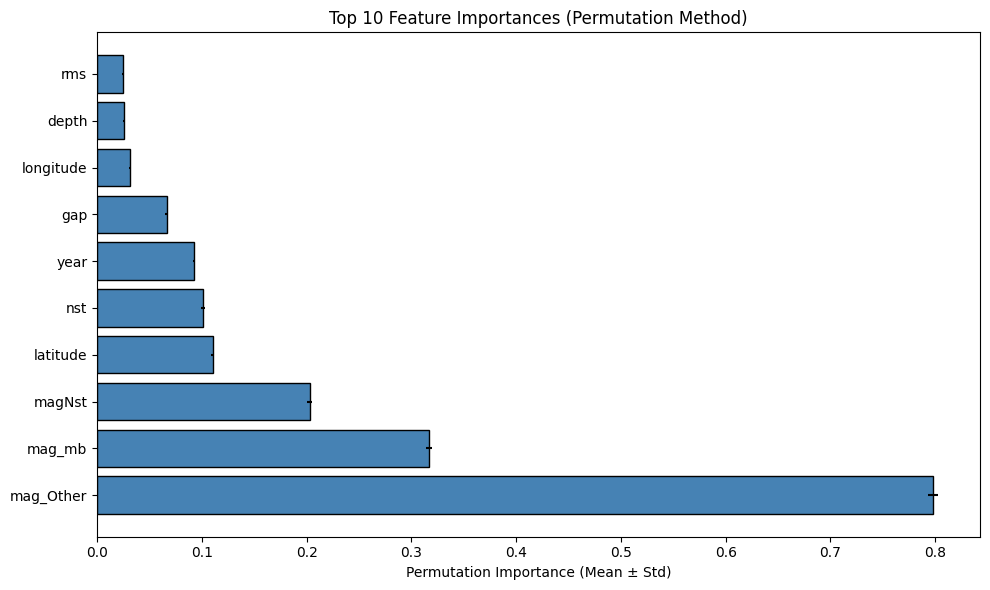

In [60]:
import shap
explainer = shap.TreeExplainer(best_stacked_model.final_estimator_)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
plt.title('Top 10 Feature Importances (SHAP)')
plt.tight_layout()
plt.savefig('plots/asia_stacked_shap_importance.png', dpi=300)
plt.show()

## Model save

In [62]:
import joblib
import os

# Save the best stacked model
joblib.dump(best_stacked_model, 'best_asia_earthquake_model.pkl')
print("✅ Model saved successfully!")

✅ Model saved successfully!
